In [1]:
import tensorflow as tf
gpu_devices=tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices: 
    tf.config.experimental.set_memory_growth(device,True)

2023-01-26 14:12:18.761248: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-26 14:12:21.495557: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-26 14:12:21.495949: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-01-26 14:12:21.495956: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from skimage.transform import resize
import glob
import joblib as jlb
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import nibabel as nib
# import cv2
from skimage.transform import resize
import tensorflow
import tensorflow as tf
import numpy as np
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
import seaborn as sns
# from sklearn.model_selection import cross_val_score

In [3]:
# import joblib as jlb
# c,s=jlb.load("new_d15.data")
# c,s=jlb.load("new_children.data")

In [4]:
def LoadData(p1,p2):
    data_ = nib.load(p1).get_fdata()
    data = np.transpose(data_,(2,0,1))
    for i in range(data.shape[0]):
        data[i]=data[i]/1000.0 
    # convert image data from (512,512) to (512,512,1)
    data = data[...,np.newaxis]
    label_ = nib.load(p2).get_fdata()
    label = np.transpose(label_,(2,0,1))   
    label = label[...,np.newaxis]
    return data,label

In [ ]:
fns1 = sorted(glob.glob('c/*'))
fns2 = sorted(glob.glob('s/*'))
Data,GT=LoadData(fns1[0],fns2[0])
for i in range(1,len(fns1)):
    im1,im2=LoadData(fns1[i],fns2[i])
    Data = np.concatenate((Data, im1), axis=0)  
    GT = np.concatenate((GT, im2), axis=0) 

In [ ]:
print(Data.shape)
print(GT.shape)

In [5]:
def train_test(x,y):
    p = int(x.shape[0] * 0.8)
    
    x_train = x[0:p]
    x_test = x[p:]
    y_train = y[0:p]
    y_test = y[p:]
    
    return x_train,y_train,x_test,y_test

In [6]:
import joblib as jlb
GT,Data=jlb.load("clean_mask_unmask")

In [7]:
Data = np.expand_dims(Data,axis=3)
GT = np.expand_dims(GT,axis=3)

In [8]:
xtr,ytr,xte,yte = train_test(Data,GT)

In [9]:
print(xtr.shape)
print(xte.shape)
print(ytr.shape)
print(yte.shape)

(1388, 512, 512, 1)
(348, 512, 512, 1)
(1388, 512, 512, 1)
(348, 512, 512, 1)


In [10]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Activation, ReLU
from tensorflow.keras.layers import BatchNormalization, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model, Sequential

In [11]:
def convolution_operation(entered_input, filters=64):
    # Taking first input and implementing the first conv block
    conv1 = Conv2D(filters, kernel_size = (3,3), padding = "same")(entered_input)
    batch_norm1 = BatchNormalization()(conv1)
    act1 = ReLU()(batch_norm1)
    
    # Taking first input and implementing the second conv block
    conv2 = Conv2D(filters, kernel_size = (3,3), padding = "same")(act1)
    batch_norm2 = BatchNormalization()(conv2)
    act2 = ReLU()(batch_norm2)
    
    return act2

In [12]:
def encoder(entered_input, filters=64):
    # Collect the start and end of each sub-block for normal pass and skip connections
    enc1 = convolution_operation(entered_input, filters)
    MaxPool1 = MaxPooling2D(strides = (2,2))(enc1)
    return enc1, MaxPool1

In [13]:
def decoder(entered_input, skip, filters=64):
    # Upsampling and concatenating the essential features
    Upsample = Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(entered_input)
    Connect_Skip = Concatenate()([Upsample, skip])
    out = convolution_operation(Connect_Skip, filters)
    return out

In [14]:
def U_Net(Image_Size):
    # Take the image size and shape
    input1 = Input(Image_Size)
    
    # Construct the encoder blocks
    skip1, encoder_1 = encoder(input1, 64)
    skip2, encoder_2 = encoder(encoder_1, 64*2)
    skip3, encoder_3 = encoder(encoder_2, 64*4)
    skip4, encoder_4 = encoder(encoder_3, 64*8)
    
    # Preparing the next block
    conv_block = convolution_operation(encoder_4, 64*16)
    
    # Construct the decoder blocks
    decoder_1 = decoder(conv_block, skip4, 64*8)
    decoder_2 = decoder(decoder_1, skip3, 64*4)
    decoder_3 = decoder(decoder_2, skip2, 64*2)
    decoder_4 = decoder(decoder_3, skip1, 64)
    
    out = Conv2D(1, 1, padding="same", activation="sigmoid")(decoder_4)

    model = Model(input1, out)
    return model

In [15]:
input_shape = (512,512,1)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

2023-01-26 14:12:35.297486: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-26 14:12:36.197320: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38172 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:25:00.0, compute capability: 8.0


In [16]:
x_train,y_train, x_test, y_test = xtr,ytr,xte,yte

In [17]:
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
model = U_Net(input_shape)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

num_folds=5
x2 = np.concatenate((x_train,x_test))
y2 = np.concatenate((y_train,y_test))
all_iou = []
all_history=[]
for train, test in KFold(num_folds).split(x2):
    xtrain,xtest=x2[train],x2[test]
    ytrain,ytest=y2[train],y2[test]
    histt=model.fit(xtrain,ytrain,epochs=300,shuffle=True,verbose=2,batch_size=16,validation_data=(xtest,ytest))
    
    y_pred = model.predict(xtest)
    y_pred_th = y_pred > 0.5
    intersection = np.logical_and(ytest,y_pred_th)
    union = np.logical_or(ytest,y_pred_th)
    iou_score = np.sum(intersection) / np.sum(union)
    
    all_history.append(histt)
    all_iou.append(iou_score)
    
    print("\nresult:\t",model.evaluate(xtest,ytest.astype('float32')),'\n')
    model.save_weights('Unetweights_org_300_model.h5')

Epoch 1/300


2023-01-26 14:12:45.600519: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8700
2023-01-26 14:12:46.080246: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-26 14:12:49.788138: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7ff604d63f80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-01-26 14:12:49.788181: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
2023-01-26 14:12:49.793293: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-01-26 14:12:49.860528: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-26 14:12:49.907298: I tensorflow/compiler/jit/xla_compilation

87/87 - 70s - loss: 0.1344 - accuracy: 0.9671 - val_loss: 6.0147 - val_accuracy: 0.4675 - 70s/epoch - 799ms/step
Epoch 2/300
87/87 - 42s - loss: 0.0542 - accuracy: 0.9870 - val_loss: 0.3748 - val_accuracy: 0.9274 - 42s/epoch - 482ms/step
Epoch 3/300
87/87 - 42s - loss: 0.0397 - accuracy: 0.9892 - val_loss: 0.1592 - val_accuracy: 0.9666 - 42s/epoch - 484ms/step
Epoch 4/300
87/87 - 42s - loss: 0.0331 - accuracy: 0.9900 - val_loss: 0.0782 - val_accuracy: 0.9804 - 42s/epoch - 485ms/step
Epoch 5/300
87/87 - 42s - loss: 0.0259 - accuracy: 0.9919 - val_loss: 0.0992 - val_accuracy: 0.9753 - 42s/epoch - 485ms/step
Epoch 6/300
87/87 - 42s - loss: 0.0245 - accuracy: 0.9920 - val_loss: 0.0382 - val_accuracy: 0.9867 - 42s/epoch - 485ms/step
Epoch 7/300
87/87 - 42s - loss: 0.0193 - accuracy: 0.9937 - val_loss: 0.0620 - val_accuracy: 0.9762 - 42s/epoch - 485ms/step
Epoch 8/300
87/87 - 42s - loss: 0.0177 - accuracy: 0.9942 - val_loss: 0.0448 - val_accuracy: 0.9858 - 42s/epoch - 486ms/step
Epoch 9/300


Epoch 67/300
87/87 - 42s - loss: 0.0037 - accuracy: 0.9984 - val_loss: 0.0237 - val_accuracy: 0.9935 - 42s/epoch - 485ms/step
Epoch 68/300
87/87 - 42s - loss: 0.0036 - accuracy: 0.9984 - val_loss: 0.0292 - val_accuracy: 0.9930 - 42s/epoch - 484ms/step
Epoch 69/300
87/87 - 42s - loss: 0.0034 - accuracy: 0.9985 - val_loss: 0.0244 - val_accuracy: 0.9935 - 42s/epoch - 485ms/step
Epoch 70/300
87/87 - 42s - loss: 0.0034 - accuracy: 0.9985 - val_loss: 0.0246 - val_accuracy: 0.9934 - 42s/epoch - 485ms/step
Epoch 71/300
87/87 - 42s - loss: 0.0034 - accuracy: 0.9985 - val_loss: 0.0288 - val_accuracy: 0.9933 - 42s/epoch - 485ms/step
Epoch 72/300
87/87 - 42s - loss: 0.0032 - accuracy: 0.9986 - val_loss: 0.0282 - val_accuracy: 0.9933 - 42s/epoch - 485ms/step
Epoch 73/300
87/87 - 42s - loss: 0.0032 - accuracy: 0.9986 - val_loss: 0.0280 - val_accuracy: 0.9932 - 42s/epoch - 485ms/step
Epoch 74/300
87/87 - 42s - loss: 0.0033 - accuracy: 0.9986 - val_loss: 0.0266 - val_accuracy: 0.9935 - 42s/epoch - 485

Epoch 132/300
87/87 - 42s - loss: 0.0022 - accuracy: 0.9991 - val_loss: 0.0416 - val_accuracy: 0.9931 - 42s/epoch - 485ms/step
Epoch 133/300
87/87 - 42s - loss: 0.0022 - accuracy: 0.9990 - val_loss: 0.0367 - val_accuracy: 0.9931 - 42s/epoch - 485ms/step
Epoch 134/300
87/87 - 42s - loss: 0.0021 - accuracy: 0.9991 - val_loss: 0.0358 - val_accuracy: 0.9928 - 42s/epoch - 485ms/step
Epoch 135/300
87/87 - 42s - loss: 0.0022 - accuracy: 0.9991 - val_loss: 0.0465 - val_accuracy: 0.9925 - 42s/epoch - 485ms/step
Epoch 136/300
87/87 - 42s - loss: 0.0022 - accuracy: 0.9991 - val_loss: 0.0486 - val_accuracy: 0.9906 - 42s/epoch - 484ms/step
Epoch 137/300
87/87 - 42s - loss: 0.0021 - accuracy: 0.9991 - val_loss: 0.0420 - val_accuracy: 0.9931 - 42s/epoch - 484ms/step
Epoch 138/300
87/87 - 42s - loss: 0.0021 - accuracy: 0.9991 - val_loss: 0.0409 - val_accuracy: 0.9932 - 42s/epoch - 484ms/step
Epoch 139/300
87/87 - 42s - loss: 0.0020 - accuracy: 0.9991 - val_loss: 0.0421 - val_accuracy: 0.9926 - 42s/epo

Epoch 197/300
87/87 - 42s - loss: 0.0016 - accuracy: 0.9993 - val_loss: 0.0463 - val_accuracy: 0.9930 - 42s/epoch - 485ms/step
Epoch 198/300
87/87 - 42s - loss: 0.0016 - accuracy: 0.9993 - val_loss: 0.0480 - val_accuracy: 0.9930 - 42s/epoch - 485ms/step
Epoch 199/300
87/87 - 42s - loss: 0.0016 - accuracy: 0.9993 - val_loss: 0.0437 - val_accuracy: 0.9926 - 42s/epoch - 485ms/step
Epoch 200/300
87/87 - 42s - loss: 0.0016 - accuracy: 0.9993 - val_loss: 0.0495 - val_accuracy: 0.9928 - 42s/epoch - 485ms/step
Epoch 201/300
87/87 - 42s - loss: 0.0015 - accuracy: 0.9993 - val_loss: 0.0473 - val_accuracy: 0.9934 - 42s/epoch - 485ms/step
Epoch 202/300
87/87 - 42s - loss: 0.0015 - accuracy: 0.9994 - val_loss: 0.0494 - val_accuracy: 0.9929 - 42s/epoch - 484ms/step
Epoch 203/300
87/87 - 42s - loss: 0.0015 - accuracy: 0.9994 - val_loss: 0.0497 - val_accuracy: 0.9931 - 42s/epoch - 484ms/step
Epoch 204/300
87/87 - 42s - loss: 0.0015 - accuracy: 0.9994 - val_loss: 0.0497 - val_accuracy: 0.9930 - 42s/epo

Epoch 262/300
87/87 - 42s - loss: 0.0010 - accuracy: 0.9996 - val_loss: 0.0619 - val_accuracy: 0.9930 - 42s/epoch - 485ms/step
Epoch 263/300
87/87 - 42s - loss: 0.0010 - accuracy: 0.9996 - val_loss: 0.0679 - val_accuracy: 0.9929 - 42s/epoch - 485ms/step
Epoch 264/300
87/87 - 42s - loss: 0.0010 - accuracy: 0.9996 - val_loss: 0.0675 - val_accuracy: 0.9932 - 42s/epoch - 485ms/step
Epoch 265/300
87/87 - 42s - loss: 9.7236e-04 - accuracy: 0.9996 - val_loss: 0.0725 - val_accuracy: 0.9930 - 42s/epoch - 485ms/step
Epoch 266/300
87/87 - 42s - loss: 9.4816e-04 - accuracy: 0.9996 - val_loss: 0.0681 - val_accuracy: 0.9933 - 42s/epoch - 485ms/step
Epoch 267/300
87/87 - 42s - loss: 9.5378e-04 - accuracy: 0.9996 - val_loss: 0.0713 - val_accuracy: 0.9932 - 42s/epoch - 485ms/step
Epoch 268/300
87/87 - 42s - loss: 9.9712e-04 - accuracy: 0.9996 - val_loss: 0.0726 - val_accuracy: 0.9928 - 42s/epoch - 485ms/step
Epoch 269/300
87/87 - 42s - loss: 9.4695e-04 - accuracy: 0.9996 - val_loss: 0.0727 - val_accura

87/87 - 42s - loss: 0.0018 - accuracy: 0.9992 - val_loss: 0.0065 - val_accuracy: 0.9973 - 42s/epoch - 485ms/step
Epoch 25/300
87/87 - 42s - loss: 0.0017 - accuracy: 0.9992 - val_loss: 0.0067 - val_accuracy: 0.9973 - 42s/epoch - 485ms/step
Epoch 26/300
87/87 - 42s - loss: 0.0017 - accuracy: 0.9993 - val_loss: 0.0077 - val_accuracy: 0.9970 - 42s/epoch - 485ms/step
Epoch 27/300
87/87 - 42s - loss: 0.0016 - accuracy: 0.9993 - val_loss: 0.0069 - val_accuracy: 0.9972 - 42s/epoch - 484ms/step
Epoch 28/300
87/87 - 42s - loss: 0.0016 - accuracy: 0.9993 - val_loss: 0.0080 - val_accuracy: 0.9969 - 42s/epoch - 484ms/step
Epoch 29/300
87/87 - 42s - loss: 0.0016 - accuracy: 0.9993 - val_loss: 0.0071 - val_accuracy: 0.9972 - 42s/epoch - 484ms/step
Epoch 30/300
87/87 - 42s - loss: 0.0015 - accuracy: 0.9993 - val_loss: 0.0069 - val_accuracy: 0.9973 - 42s/epoch - 484ms/step
Epoch 31/300
87/87 - 42s - loss: 0.0015 - accuracy: 0.9993 - val_loss: 0.0081 - val_accuracy: 0.9969 - 42s/epoch - 484ms/step
Epoch

Epoch 89/300
87/87 - 42s - loss: 7.3489e-04 - accuracy: 0.9997 - val_loss: 0.0120 - val_accuracy: 0.9971 - 42s/epoch - 485ms/step
Epoch 90/300
87/87 - 42s - loss: 6.9171e-04 - accuracy: 0.9997 - val_loss: 0.0123 - val_accuracy: 0.9970 - 42s/epoch - 484ms/step
Epoch 91/300
87/87 - 42s - loss: 6.3974e-04 - accuracy: 0.9997 - val_loss: 0.0112 - val_accuracy: 0.9972 - 42s/epoch - 484ms/step
Epoch 92/300
87/87 - 42s - loss: 6.4718e-04 - accuracy: 0.9997 - val_loss: 0.0129 - val_accuracy: 0.9969 - 42s/epoch - 484ms/step
Epoch 93/300
87/87 - 42s - loss: 6.6826e-04 - accuracy: 0.9997 - val_loss: 0.0128 - val_accuracy: 0.9970 - 42s/epoch - 484ms/step
Epoch 94/300
87/87 - 42s - loss: 6.4031e-04 - accuracy: 0.9997 - val_loss: 0.0122 - val_accuracy: 0.9971 - 42s/epoch - 484ms/step
Epoch 95/300
87/87 - 42s - loss: 6.5788e-04 - accuracy: 0.9997 - val_loss: 0.0128 - val_accuracy: 0.9970 - 42s/epoch - 484ms/step
Epoch 96/300
87/87 - 42s - loss: 6.2862e-04 - accuracy: 0.9997 - val_loss: 0.0134 - val_ac

Epoch 152/300
87/87 - 42s - loss: 3.8543e-04 - accuracy: 0.9999 - val_loss: 0.0166 - val_accuracy: 0.9968 - 42s/epoch - 485ms/step
Epoch 153/300
87/87 - 42s - loss: 3.8353e-04 - accuracy: 0.9999 - val_loss: 0.0164 - val_accuracy: 0.9969 - 42s/epoch - 485ms/step
Epoch 154/300
87/87 - 42s - loss: 4.2846e-04 - accuracy: 0.9998 - val_loss: 0.0161 - val_accuracy: 0.9969 - 42s/epoch - 485ms/step
Epoch 155/300
87/87 - 42s - loss: 4.4961e-04 - accuracy: 0.9998 - val_loss: 0.0177 - val_accuracy: 0.9965 - 42s/epoch - 485ms/step
Epoch 156/300
87/87 - 42s - loss: 4.4616e-04 - accuracy: 0.9998 - val_loss: 0.0157 - val_accuracy: 0.9970 - 42s/epoch - 485ms/step
Epoch 157/300
87/87 - 42s - loss: 3.9519e-04 - accuracy: 0.9998 - val_loss: 0.0154 - val_accuracy: 0.9970 - 42s/epoch - 485ms/step
Epoch 158/300
87/87 - 42s - loss: 3.9615e-04 - accuracy: 0.9998 - val_loss: 0.0163 - val_accuracy: 0.9969 - 42s/epoch - 485ms/step
Epoch 159/300
87/87 - 42s - loss: 3.6722e-04 - accuracy: 0.9999 - val_loss: 0.0152 

Epoch 215/300
87/87 - 42s - loss: 1.8873e-04 - accuracy: 0.9999 - val_loss: 0.0206 - val_accuracy: 0.9970 - 42s/epoch - 485ms/step
Epoch 216/300
87/87 - 42s - loss: 1.5778e-04 - accuracy: 0.9999 - val_loss: 0.0215 - val_accuracy: 0.9969 - 42s/epoch - 485ms/step
Epoch 217/300
87/87 - 42s - loss: 2.1353e-04 - accuracy: 0.9999 - val_loss: 0.0212 - val_accuracy: 0.9969 - 42s/epoch - 485ms/step
Epoch 218/300
87/87 - 42s - loss: 2.2492e-04 - accuracy: 0.9999 - val_loss: 0.0210 - val_accuracy: 0.9969 - 42s/epoch - 485ms/step
Epoch 219/300
87/87 - 42s - loss: 2.9662e-04 - accuracy: 0.9999 - val_loss: 0.0203 - val_accuracy: 0.9969 - 42s/epoch - 485ms/step
Epoch 220/300
87/87 - 42s - loss: 2.5451e-04 - accuracy: 0.9999 - val_loss: 0.0216 - val_accuracy: 0.9967 - 42s/epoch - 485ms/step
Epoch 221/300
87/87 - 42s - loss: 1.9381e-04 - accuracy: 0.9999 - val_loss: 0.0213 - val_accuracy: 0.9969 - 42s/epoch - 485ms/step
Epoch 222/300
87/87 - 42s - loss: 1.5700e-04 - accuracy: 0.9999 - val_loss: 0.0232 

Epoch 278/300
87/87 - 42s - loss: 1.4056e-04 - accuracy: 1.0000 - val_loss: 0.0238 - val_accuracy: 0.9970 - 42s/epoch - 485ms/step
Epoch 279/300
87/87 - 42s - loss: 1.8624e-04 - accuracy: 0.9999 - val_loss: 0.0239 - val_accuracy: 0.9969 - 42s/epoch - 486ms/step
Epoch 280/300
87/87 - 42s - loss: 1.2349e-04 - accuracy: 1.0000 - val_loss: 0.0262 - val_accuracy: 0.9967 - 42s/epoch - 485ms/step
Epoch 281/300
87/87 - 42s - loss: 8.3438e-05 - accuracy: 1.0000 - val_loss: 0.0266 - val_accuracy: 0.9968 - 42s/epoch - 485ms/step
Epoch 282/300
87/87 - 42s - loss: 6.1484e-05 - accuracy: 1.0000 - val_loss: 0.0267 - val_accuracy: 0.9969 - 42s/epoch - 485ms/step
Epoch 283/300
87/87 - 42s - loss: 5.3131e-05 - accuracy: 1.0000 - val_loss: 0.0281 - val_accuracy: 0.9969 - 42s/epoch - 485ms/step
Epoch 284/300
87/87 - 42s - loss: 4.7610e-05 - accuracy: 1.0000 - val_loss: 0.0291 - val_accuracy: 0.9969 - 42s/epoch - 485ms/step
Epoch 285/300
87/87 - 42s - loss: 4.4500e-05 - accuracy: 1.0000 - val_loss: 0.0306 

Epoch 40/300
87/87 - 42s - loss: 2.5792e-04 - accuracy: 0.9999 - val_loss: 0.0016 - val_accuracy: 0.9996 - 42s/epoch - 485ms/step
Epoch 41/300
87/87 - 42s - loss: 2.3524e-04 - accuracy: 0.9999 - val_loss: 0.0020 - val_accuracy: 0.9995 - 42s/epoch - 485ms/step
Epoch 42/300
87/87 - 42s - loss: 2.3676e-04 - accuracy: 0.9999 - val_loss: 0.0021 - val_accuracy: 0.9995 - 42s/epoch - 485ms/step
Epoch 43/300
87/87 - 42s - loss: 2.5133e-04 - accuracy: 0.9999 - val_loss: 0.0021 - val_accuracy: 0.9995 - 42s/epoch - 485ms/step
Epoch 44/300
87/87 - 42s - loss: 2.4059e-04 - accuracy: 0.9999 - val_loss: 0.0018 - val_accuracy: 0.9996 - 42s/epoch - 485ms/step
Epoch 45/300
87/87 - 42s - loss: 2.2104e-04 - accuracy: 0.9999 - val_loss: 0.0019 - val_accuracy: 0.9996 - 42s/epoch - 485ms/step
Epoch 46/300
87/87 - 42s - loss: 2.3271e-04 - accuracy: 0.9999 - val_loss: 0.0017 - val_accuracy: 0.9996 - 42s/epoch - 484ms/step
Epoch 47/300
87/87 - 42s - loss: 2.5950e-04 - accuracy: 0.9999 - val_loss: 0.0021 - val_ac

Epoch 103/300
87/87 - 42s - loss: 1.2767e-04 - accuracy: 1.0000 - val_loss: 0.0047 - val_accuracy: 0.9993 - 42s/epoch - 485ms/step
Epoch 104/300
87/87 - 42s - loss: 1.0493e-04 - accuracy: 1.0000 - val_loss: 0.0031 - val_accuracy: 0.9995 - 42s/epoch - 484ms/step
Epoch 105/300
87/87 - 42s - loss: 9.3547e-05 - accuracy: 1.0000 - val_loss: 0.0036 - val_accuracy: 0.9994 - 42s/epoch - 485ms/step
Epoch 106/300
87/87 - 42s - loss: 1.0409e-04 - accuracy: 1.0000 - val_loss: 0.0031 - val_accuracy: 0.9995 - 42s/epoch - 484ms/step
Epoch 107/300
87/87 - 42s - loss: 1.4239e-04 - accuracy: 1.0000 - val_loss: 0.0037 - val_accuracy: 0.9994 - 42s/epoch - 484ms/step
Epoch 108/300
87/87 - 42s - loss: 1.3974e-04 - accuracy: 1.0000 - val_loss: 0.0034 - val_accuracy: 0.9994 - 42s/epoch - 484ms/step
Epoch 109/300
87/87 - 42s - loss: 1.2528e-04 - accuracy: 1.0000 - val_loss: 0.0035 - val_accuracy: 0.9994 - 42s/epoch - 484ms/step
Epoch 110/300
87/87 - 42s - loss: 9.0111e-05 - accuracy: 1.0000 - val_loss: 0.0033 

Epoch 166/300
87/87 - 42s - loss: 6.0274e-05 - accuracy: 1.0000 - val_loss: 0.0050 - val_accuracy: 0.9993 - 42s/epoch - 484ms/step
Epoch 167/300
87/87 - 42s - loss: 5.8230e-05 - accuracy: 1.0000 - val_loss: 0.0054 - val_accuracy: 0.9993 - 42s/epoch - 484ms/step
Epoch 168/300
87/87 - 42s - loss: 6.2095e-05 - accuracy: 1.0000 - val_loss: 0.0050 - val_accuracy: 0.9993 - 42s/epoch - 484ms/step
Epoch 169/300
87/87 - 42s - loss: 7.0270e-05 - accuracy: 1.0000 - val_loss: 0.0052 - val_accuracy: 0.9993 - 42s/epoch - 485ms/step
Epoch 170/300
87/87 - 42s - loss: 7.7472e-05 - accuracy: 1.0000 - val_loss: 0.0046 - val_accuracy: 0.9994 - 42s/epoch - 484ms/step
Epoch 171/300
87/87 - 42s - loss: 7.3874e-05 - accuracy: 1.0000 - val_loss: 0.0047 - val_accuracy: 0.9993 - 42s/epoch - 485ms/step
Epoch 172/300
87/87 - 42s - loss: 6.2299e-05 - accuracy: 1.0000 - val_loss: 0.0047 - val_accuracy: 0.9993 - 42s/epoch - 485ms/step
Epoch 173/300
87/87 - 42s - loss: 5.3888e-05 - accuracy: 1.0000 - val_loss: 0.0050 

Epoch 229/300
87/87 - 42s - loss: 5.7315e-05 - accuracy: 1.0000 - val_loss: 0.0055 - val_accuracy: 0.9993 - 42s/epoch - 484ms/step
Epoch 230/300
87/87 - 43s - loss: 3.4499e-05 - accuracy: 1.0000 - val_loss: 0.0055 - val_accuracy: 0.9993 - 43s/epoch - 496ms/step
Epoch 231/300
87/87 - 42s - loss: 4.9386e-05 - accuracy: 1.0000 - val_loss: 0.0057 - val_accuracy: 0.9993 - 42s/epoch - 484ms/step
Epoch 232/300
87/87 - 42s - loss: 2.5890e-05 - accuracy: 1.0000 - val_loss: 0.0074 - val_accuracy: 0.9991 - 42s/epoch - 485ms/step
Epoch 233/300
87/87 - 42s - loss: 2.1496e-05 - accuracy: 1.0000 - val_loss: 0.0059 - val_accuracy: 0.9993 - 42s/epoch - 484ms/step
Epoch 234/300
87/87 - 42s - loss: 1.5366e-05 - accuracy: 1.0000 - val_loss: 0.0060 - val_accuracy: 0.9993 - 42s/epoch - 485ms/step
Epoch 235/300
87/87 - 42s - loss: 1.4447e-05 - accuracy: 1.0000 - val_loss: 0.0067 - val_accuracy: 0.9992 - 42s/epoch - 484ms/step
Epoch 236/300
87/87 - 42s - loss: 1.2359e-05 - accuracy: 1.0000 - val_loss: 0.0063 

Epoch 292/300
87/87 - 42s - loss: 4.1700e-05 - accuracy: 1.0000 - val_loss: 0.0079 - val_accuracy: 0.9991 - 42s/epoch - 484ms/step
Epoch 293/300
87/87 - 42s - loss: 2.8916e-05 - accuracy: 1.0000 - val_loss: 0.0079 - val_accuracy: 0.9991 - 42s/epoch - 485ms/step
Epoch 294/300
87/87 - 42s - loss: 2.3419e-05 - accuracy: 1.0000 - val_loss: 0.0083 - val_accuracy: 0.9991 - 42s/epoch - 484ms/step
Epoch 295/300
87/87 - 42s - loss: 1.8544e-05 - accuracy: 1.0000 - val_loss: 0.0084 - val_accuracy: 0.9991 - 42s/epoch - 485ms/step
Epoch 296/300
87/87 - 42s - loss: 1.2914e-05 - accuracy: 1.0000 - val_loss: 0.0087 - val_accuracy: 0.9991 - 42s/epoch - 484ms/step
Epoch 297/300
87/87 - 42s - loss: 1.3243e-05 - accuracy: 1.0000 - val_loss: 0.0090 - val_accuracy: 0.9991 - 42s/epoch - 484ms/step
Epoch 298/300
87/87 - 42s - loss: 1.5500e-05 - accuracy: 1.0000 - val_loss: 0.0093 - val_accuracy: 0.9991 - 42s/epoch - 484ms/step
Epoch 299/300
87/87 - 42s - loss: 1.8122e-05 - accuracy: 1.0000 - val_loss: 0.0094 

2023-01-27 00:46:24.587927: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.00GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-01-27 00:46:24.588234: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.01GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-01-27 00:46:25.158876: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.00GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-01-27 00:46:25.159068: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU

87/87 - 52s - loss: 0.0010 - accuracy: 0.9997 - val_loss: 6.1280e-04 - val_accuracy: 0.9998 - 52s/epoch - 593ms/step
Epoch 2/300
87/87 - 56s - loss: 6.3955e-04 - accuracy: 0.9998 - val_loss: 2.4562e-04 - val_accuracy: 0.9999 - 56s/epoch - 638ms/step
Epoch 3/300
87/87 - 56s - loss: 3.9893e-04 - accuracy: 0.9999 - val_loss: 1.2316e-04 - val_accuracy: 1.0000 - 56s/epoch - 638ms/step
Epoch 4/300
87/87 - 56s - loss: 2.7817e-04 - accuracy: 0.9999 - val_loss: 2.3536e-04 - val_accuracy: 0.9999 - 56s/epoch - 638ms/step
Epoch 5/300
87/87 - 56s - loss: 2.0408e-04 - accuracy: 0.9999 - val_loss: 1.0058e-04 - val_accuracy: 1.0000 - 56s/epoch - 638ms/step
Epoch 6/300
87/87 - 55s - loss: 1.8647e-04 - accuracy: 0.9999 - val_loss: 1.0263e-04 - val_accuracy: 1.0000 - 55s/epoch - 638ms/step
Epoch 7/300
87/87 - 55s - loss: 1.8593e-04 - accuracy: 0.9999 - val_loss: 4.7910e-04 - val_accuracy: 0.9999 - 55s/epoch - 638ms/step
Epoch 8/300
87/87 - 55s - loss: 1.5599e-04 - accuracy: 0.9999 - val_loss: 8.8881e-05 

Epoch 63/300
87/87 - 55s - loss: 1.0131e-04 - accuracy: 1.0000 - val_loss: 1.6999e-04 - val_accuracy: 0.9999 - 55s/epoch - 638ms/step
Epoch 64/300
87/87 - 55s - loss: 7.8908e-05 - accuracy: 1.0000 - val_loss: 2.2825e-04 - val_accuracy: 0.9999 - 55s/epoch - 637ms/step
Epoch 65/300
87/87 - 55s - loss: 4.8647e-05 - accuracy: 1.0000 - val_loss: 2.4719e-04 - val_accuracy: 0.9999 - 55s/epoch - 637ms/step
Epoch 66/300
87/87 - 55s - loss: 4.0275e-05 - accuracy: 1.0000 - val_loss: 1.2809e-04 - val_accuracy: 1.0000 - 55s/epoch - 637ms/step
Epoch 67/300
87/87 - 55s - loss: 2.4549e-05 - accuracy: 1.0000 - val_loss: 1.0588e-04 - val_accuracy: 1.0000 - 55s/epoch - 638ms/step
Epoch 68/300
87/87 - 55s - loss: 1.7305e-05 - accuracy: 1.0000 - val_loss: 1.1838e-04 - val_accuracy: 1.0000 - 55s/epoch - 638ms/step
Epoch 69/300
87/87 - 55s - loss: 1.1870e-05 - accuracy: 1.0000 - val_loss: 1.6754e-04 - val_accuracy: 1.0000 - 55s/epoch - 638ms/step
Epoch 70/300
87/87 - 56s - loss: 9.1609e-06 - accuracy: 1.0000

Epoch 124/300
87/87 - 55s - loss: 1.3305e-05 - accuracy: 1.0000 - val_loss: 2.2817e-04 - val_accuracy: 0.9999 - 55s/epoch - 638ms/step
Epoch 125/300
87/87 - 55s - loss: 1.6161e-05 - accuracy: 1.0000 - val_loss: 6.5817e-04 - val_accuracy: 0.9999 - 55s/epoch - 637ms/step
Epoch 126/300
87/87 - 55s - loss: 2.0791e-05 - accuracy: 1.0000 - val_loss: 5.7324e-04 - val_accuracy: 0.9999 - 55s/epoch - 638ms/step
Epoch 127/300
87/87 - 55s - loss: 4.9092e-05 - accuracy: 1.0000 - val_loss: 0.0014 - val_accuracy: 0.9998 - 55s/epoch - 638ms/step
Epoch 128/300
87/87 - 55s - loss: 7.1568e-05 - accuracy: 1.0000 - val_loss: 4.5601e-04 - val_accuracy: 0.9999 - 55s/epoch - 638ms/step
Epoch 129/300
87/87 - 55s - loss: 7.2022e-05 - accuracy: 1.0000 - val_loss: 3.5438e-04 - val_accuracy: 0.9999 - 55s/epoch - 638ms/step
Epoch 130/300
87/87 - 55s - loss: 6.0666e-05 - accuracy: 1.0000 - val_loss: 4.1715e-04 - val_accuracy: 0.9999 - 55s/epoch - 638ms/step
Epoch 131/300
87/87 - 55s - loss: 4.2897e-05 - accuracy: 1.

Epoch 185/300
87/87 - 56s - loss: 2.7858e-05 - accuracy: 1.0000 - val_loss: 2.6601e-04 - val_accuracy: 0.9999 - 56s/epoch - 638ms/step
Epoch 186/300
87/87 - 56s - loss: 4.4517e-05 - accuracy: 1.0000 - val_loss: 5.2522e-04 - val_accuracy: 0.9999 - 56s/epoch - 638ms/step
Epoch 187/300
87/87 - 56s - loss: 7.9196e-05 - accuracy: 1.0000 - val_loss: 4.1451e-04 - val_accuracy: 0.9999 - 56s/epoch - 638ms/step
Epoch 188/300
87/87 - 56s - loss: 6.4443e-05 - accuracy: 1.0000 - val_loss: 0.0135 - val_accuracy: 0.9986 - 56s/epoch - 638ms/step
Epoch 189/300
87/87 - 55s - loss: 5.1809e-05 - accuracy: 1.0000 - val_loss: 3.3884e-04 - val_accuracy: 0.9999 - 55s/epoch - 638ms/step
Epoch 190/300
87/87 - 56s - loss: 3.4227e-05 - accuracy: 1.0000 - val_loss: 2.4610e-04 - val_accuracy: 0.9999 - 56s/epoch - 638ms/step
Epoch 191/300
87/87 - 56s - loss: 2.1201e-05 - accuracy: 1.0000 - val_loss: 2.4684e-04 - val_accuracy: 0.9999 - 56s/epoch - 638ms/step
Epoch 192/300
87/87 - 56s - loss: 1.1411e-05 - accuracy: 1.

Epoch 246/300
87/87 - 56s - loss: 2.7321e-05 - accuracy: 1.0000 - val_loss: 3.3095e-04 - val_accuracy: 0.9999 - 56s/epoch - 638ms/step
Epoch 247/300
87/87 - 56s - loss: 1.3147e-05 - accuracy: 1.0000 - val_loss: 5.1269e-04 - val_accuracy: 0.9999 - 56s/epoch - 638ms/step
Epoch 248/300
87/87 - 56s - loss: 6.6110e-06 - accuracy: 1.0000 - val_loss: 3.3218e-04 - val_accuracy: 0.9999 - 56s/epoch - 638ms/step
Epoch 249/300
87/87 - 56s - loss: 3.9990e-06 - accuracy: 1.0000 - val_loss: 2.8987e-04 - val_accuracy: 0.9999 - 56s/epoch - 638ms/step
Epoch 250/300
87/87 - 56s - loss: 3.7918e-06 - accuracy: 1.0000 - val_loss: 3.1632e-04 - val_accuracy: 0.9999 - 56s/epoch - 638ms/step
Epoch 251/300
87/87 - 56s - loss: 2.4793e-06 - accuracy: 1.0000 - val_loss: 4.0766e-04 - val_accuracy: 0.9999 - 56s/epoch - 639ms/step
Epoch 252/300
87/87 - 58s - loss: 1.8051e-06 - accuracy: 1.0000 - val_loss: 3.0653e-04 - val_accuracy: 0.9999 - 58s/epoch - 664ms/step
Epoch 253/300
87/87 - 56s - loss: 1.4936e-06 - accuracy

Epoch 6/300
87/87 - 42s - loss: 2.1092e-05 - accuracy: 1.0000 - val_loss: 1.8952e-05 - val_accuracy: 1.0000 - 42s/epoch - 484ms/step
Epoch 7/300
87/87 - 42s - loss: 1.4120e-05 - accuracy: 1.0000 - val_loss: 1.6038e-05 - val_accuracy: 1.0000 - 42s/epoch - 484ms/step
Epoch 8/300
87/87 - 42s - loss: 1.0241e-05 - accuracy: 1.0000 - val_loss: 1.1893e-05 - val_accuracy: 1.0000 - 42s/epoch - 484ms/step
Epoch 9/300
87/87 - 42s - loss: 9.5882e-06 - accuracy: 1.0000 - val_loss: 1.1991e-05 - val_accuracy: 1.0000 - 42s/epoch - 484ms/step
Epoch 10/300
87/87 - 42s - loss: 8.2953e-06 - accuracy: 1.0000 - val_loss: 2.0884e-05 - val_accuracy: 1.0000 - 42s/epoch - 484ms/step
Epoch 11/300
87/87 - 42s - loss: 6.5135e-06 - accuracy: 1.0000 - val_loss: 4.4329e-05 - val_accuracy: 1.0000 - 42s/epoch - 484ms/step
Epoch 12/300
87/87 - 42s - loss: 9.9453e-06 - accuracy: 1.0000 - val_loss: 3.1682e-05 - val_accuracy: 1.0000 - 42s/epoch - 484ms/step
Epoch 13/300
87/87 - 42s - loss: 1.4317e-05 - accuracy: 1.0000 - v

Epoch 68/300
87/87 - 42s - loss: 7.1883e-06 - accuracy: 1.0000 - val_loss: 2.3654e-05 - val_accuracy: 1.0000 - 42s/epoch - 484ms/step
Epoch 69/300
87/87 - 42s - loss: 7.8651e-06 - accuracy: 1.0000 - val_loss: 2.5660e-05 - val_accuracy: 1.0000 - 42s/epoch - 484ms/step
Epoch 70/300
87/87 - 42s - loss: 1.2895e-05 - accuracy: 1.0000 - val_loss: 1.9778e-04 - val_accuracy: 0.9999 - 42s/epoch - 484ms/step
Epoch 71/300
87/87 - 42s - loss: 2.3262e-05 - accuracy: 1.0000 - val_loss: 5.2054e-05 - val_accuracy: 1.0000 - 42s/epoch - 484ms/step
Epoch 72/300
87/87 - 42s - loss: 2.2835e-05 - accuracy: 1.0000 - val_loss: 4.2643e-05 - val_accuracy: 1.0000 - 42s/epoch - 484ms/step
Epoch 73/300
87/87 - 42s - loss: 1.8819e-05 - accuracy: 1.0000 - val_loss: 2.1526e-04 - val_accuracy: 0.9999 - 42s/epoch - 484ms/step
Epoch 74/300
87/87 - 42s - loss: 1.7571e-05 - accuracy: 1.0000 - val_loss: 5.4169e-05 - val_accuracy: 1.0000 - 42s/epoch - 484ms/step
Epoch 75/300
87/87 - 42s - loss: 1.6567e-05 - accuracy: 1.0000

87/87 - 42s - loss: 6.8644e-06 - accuracy: 1.0000 - val_loss: 2.8403e-04 - val_accuracy: 0.9999 - 42s/epoch - 484ms/step
Epoch 130/300
87/87 - 42s - loss: 7.5042e-06 - accuracy: 1.0000 - val_loss: 2.9495e-04 - val_accuracy: 0.9999 - 42s/epoch - 485ms/step
Epoch 131/300
87/87 - 42s - loss: 9.0295e-06 - accuracy: 1.0000 - val_loss: 2.9676e-04 - val_accuracy: 0.9999 - 42s/epoch - 484ms/step
Epoch 132/300
87/87 - 42s - loss: 9.8938e-06 - accuracy: 1.0000 - val_loss: 7.7345e-05 - val_accuracy: 1.0000 - 42s/epoch - 484ms/step
Epoch 133/300
87/87 - 42s - loss: 1.1403e-05 - accuracy: 1.0000 - val_loss: 8.3891e-05 - val_accuracy: 1.0000 - 42s/epoch - 484ms/step
Epoch 134/300
87/87 - 42s - loss: 1.1721e-05 - accuracy: 1.0000 - val_loss: 9.2643e-05 - val_accuracy: 1.0000 - 42s/epoch - 485ms/step
Epoch 135/300
87/87 - 42s - loss: 1.3018e-05 - accuracy: 1.0000 - val_loss: 1.1296e-04 - val_accuracy: 1.0000 - 42s/epoch - 484ms/step
Epoch 136/300
87/87 - 42s - loss: 2.3840e-05 - accuracy: 1.0000 - val

Epoch 190/300
87/87 - 42s - loss: 1.1013e-05 - accuracy: 1.0000 - val_loss: 2.1796e-04 - val_accuracy: 0.9999 - 42s/epoch - 484ms/step
Epoch 191/300
87/87 - 42s - loss: 1.2460e-05 - accuracy: 1.0000 - val_loss: 1.6478e-04 - val_accuracy: 1.0000 - 42s/epoch - 484ms/step
Epoch 192/300
87/87 - 42s - loss: 1.6017e-05 - accuracy: 1.0000 - val_loss: 1.1365e-04 - val_accuracy: 1.0000 - 42s/epoch - 484ms/step
Epoch 193/300
87/87 - 42s - loss: 1.4582e-05 - accuracy: 1.0000 - val_loss: 8.0340e-04 - val_accuracy: 0.9998 - 42s/epoch - 484ms/step
Epoch 194/300
87/87 - 42s - loss: 1.4658e-05 - accuracy: 1.0000 - val_loss: 2.7099e-04 - val_accuracy: 0.9999 - 42s/epoch - 484ms/step
Epoch 195/300
87/87 - 42s - loss: 1.4082e-05 - accuracy: 1.0000 - val_loss: 1.0641e-04 - val_accuracy: 1.0000 - 42s/epoch - 484ms/step
Epoch 196/300
87/87 - 42s - loss: 1.2593e-05 - accuracy: 1.0000 - val_loss: 3.7064e-04 - val_accuracy: 0.9999 - 42s/epoch - 484ms/step
Epoch 197/300
87/87 - 42s - loss: 1.4539e-05 - accuracy

Epoch 251/300
87/87 - 42s - loss: 1.1925e-06 - accuracy: 1.0000 - val_loss: 1.1029e-04 - val_accuracy: 1.0000 - 42s/epoch - 484ms/step
Epoch 252/300
87/87 - 42s - loss: 9.9350e-07 - accuracy: 1.0000 - val_loss: 1.0732e-04 - val_accuracy: 1.0000 - 42s/epoch - 484ms/step
Epoch 253/300
87/87 - 42s - loss: 1.0986e-06 - accuracy: 1.0000 - val_loss: 1.1108e-04 - val_accuracy: 1.0000 - 42s/epoch - 484ms/step
Epoch 254/300
87/87 - 42s - loss: 7.8406e-07 - accuracy: 1.0000 - val_loss: 8.3954e-05 - val_accuracy: 1.0000 - 42s/epoch - 484ms/step
Epoch 255/300
87/87 - 42s - loss: 6.8336e-07 - accuracy: 1.0000 - val_loss: 9.3566e-05 - val_accuracy: 1.0000 - 42s/epoch - 484ms/step
Epoch 256/300
87/87 - 42s - loss: 5.5493e-07 - accuracy: 1.0000 - val_loss: 8.2255e-05 - val_accuracy: 1.0000 - 42s/epoch - 484ms/step
Epoch 257/300
87/87 - 42s - loss: 5.6966e-07 - accuracy: 1.0000 - val_loss: 8.4740e-05 - val_accuracy: 1.0000 - 42s/epoch - 484ms/step
Epoch 258/300
87/87 - 42s - loss: 8.6290e-07 - accuracy

In [18]:
all_iou

[0.8003550858608272,
 0.8663292534852168,
 0.9613293808742617,
 0.996007717390078,
 0.9976548269581057]

In [19]:
np.mean(np.array(all_iou))

0.9243352529136979

In [33]:
loss = all_history.history['loss']
loss.shape

AttributeError: 'list' object has no attribute 'history'

In [42]:
def Plot_ACC_LOSS(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    loss=loss[:20]
    val_loss=val_loss[:20]
    epochs=20
    epochs = range(1,len(loss)+1)
    plt.plot(epochs,loss,'y',label='Traning loss')
    plt.plot(epochs,val_loss,'r',label='Validation loss')
    plt.title('Traning and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

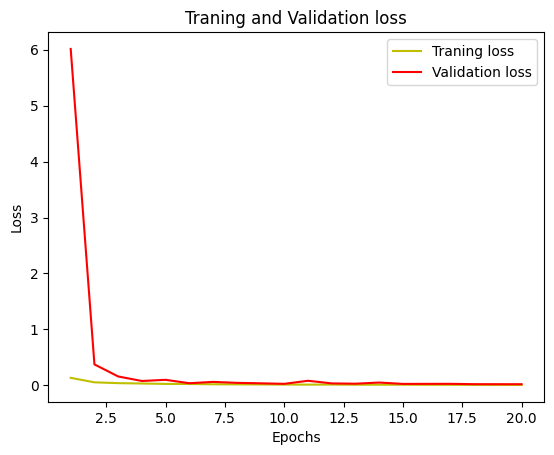

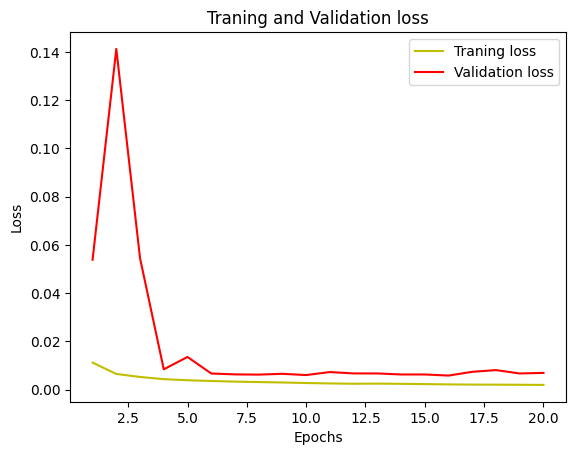

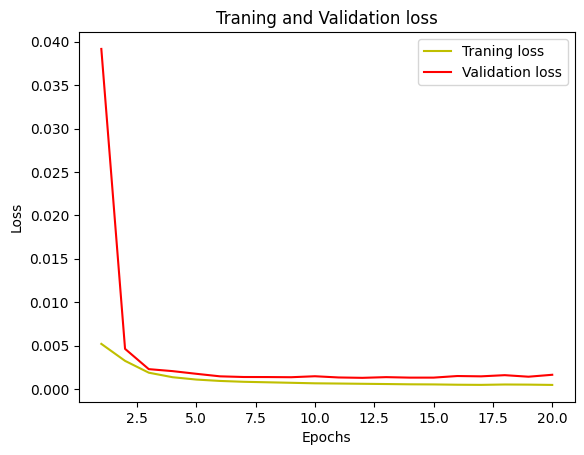

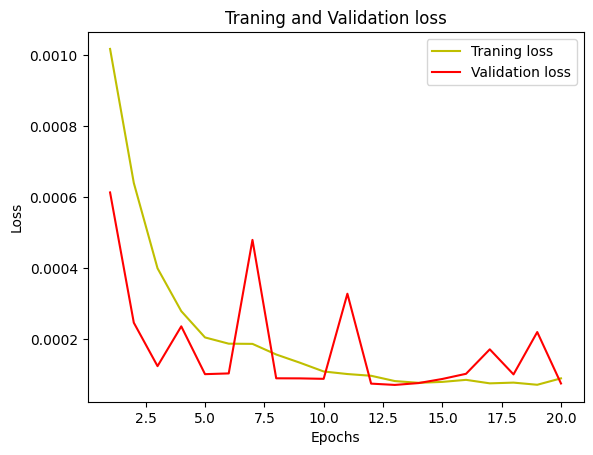

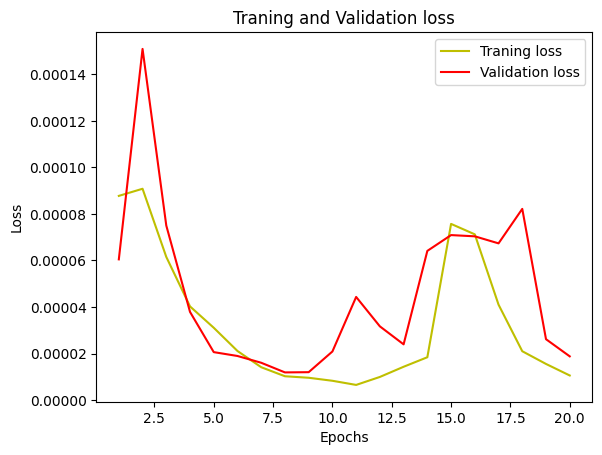

<Figure size 640x480 with 0 Axes>

In [43]:
for i in range (len(all_history)):
    Plot_ACC_LOSS(all_history[i])
    plt.savefig("Unet_org_300_plot"+str(i)+".png")
model.save("Unet_org_300_model.h5")

In [ ]:
# *************

In [ ]:
import time
time_start=time.time()

hist= []
model = U_Net(input_shape)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model, doing validation at the end of each epoch.
epochs = 50
histt=model.fit(xtr,ytr.astype('float32'), epochs=epochs,verbose=2, batch_size=16, validation_data=(xte,yte))
hist.append(histt)
print("\nresult:\t",model.evaluate(xte,yte.astype('float32')),'\n')

print("Time: ")
print(time.time()-time_start)

In [ ]:

#n_class=1
_,acc = model.evaluate(xte,yte)
print("Accuracy is :",(acc * 100.0),"%")


# model.load_weights("seg-5class.hdf5")

y_pred = model.predict(xte)

y_pred_th = y_pred > 0.5
intersection = np.logical_and(yte,y_pred_th)
union = np.logical_or(yte,y_pred_th)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU score is:",iou_score) 


In [ ]:
import numpy as np
pred=model.predict(xte)
pred = np.where(pred>0.5 ,1.,0.)

In [ ]:
intersection=np.logical_and(pred,yte)
unit=np.logical_or(pred,yte)
iou=np.sum(intersection)/np.sum(unit)
iou

In [ ]:
FP = len(np.where(pred - yte == 1.)[0])
FN = len(np.where(pred - yte == -1.)[0])
TP = len(np.where(pred + yte == 2.)[0])
TN = len(np.where(pred + yte == 0.)[0])
cmat = [[TP,FN],[FP,TN]]
print(cmat)
plt.figure(figsize=(6,6))
sns.heatmap(cmat/np.sum(cmat),cmap="Reds",annot=True,fmt='.2%',square=1,linewidth=2.)
plt.xlabel('Predict')
plt.ylabel('real')
plt.show()
presicion = TP / (TP+FP)
recall = TP / (TP+FN)
F1 = 2 * (presicion*recall)/(presicion+recall)
Pixel_accuracy=(TP+TN)/(TP+TN+FP+FN)
dice=(2*TP)/(2*TP+FP+FN)
iou=TP/(TP+FP+FN)

print("presicion: ",presicion)
print("recall: ",recall)
print("F1-Score: ",F1)
print("Pixel_accuracy: ",Pixel_accuracy)
print("dice: ",dice)
print("IoU: ",iou)

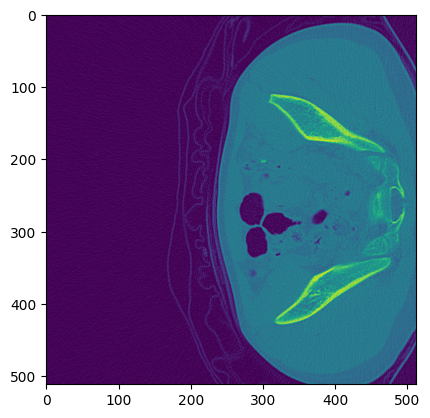

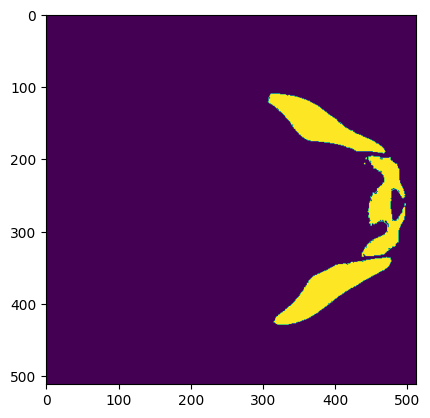

NameError: name 'pred' is not defined

In [23]:
plt.imshow(xte[100])
plt.show()
plt.imshow(yte[100])
plt.show()
plt.imshow(pred[100])
plt.show()

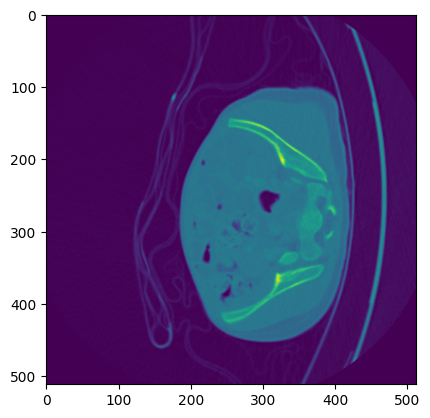

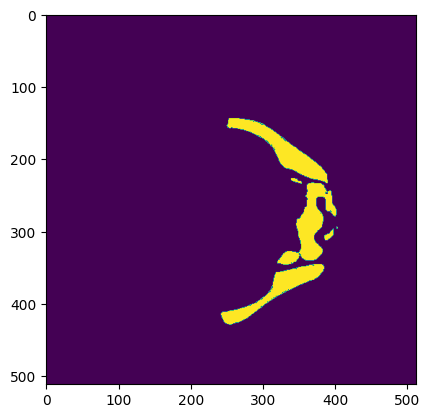

NameError: name 'pred' is not defined

In [24]:
plt.imshow(xte[320])
plt.show()
plt.imshow(yte[320])
plt.show()
plt.imshow(pred[320])
plt.show()

1/1 [==============================] - 1s 928ms/step


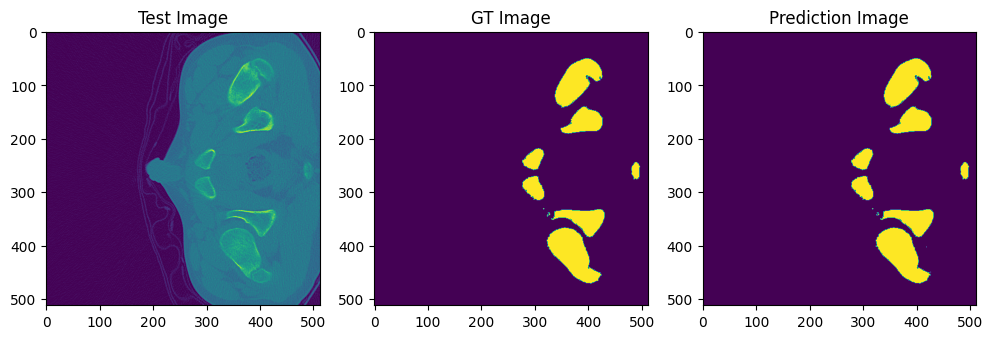

In [25]:
n_test_img = np.random.randint(0,len(x_test)-1)
test_img = x_test[n_test_img]
GT = y_test[n_test_img]
test_img_input = np.expand_dims(test_img,axis=0)
prediction = (model.predict(test_img_input)[0] > 0.5).astype(np.uint8)

plt.figure(figsize=(12,8))
plt.subplot(131)
plt.title('Test Image')
plt.imshow(test_img)
plt.subplot(132)
plt.title('GT Image')
plt.imshow(GT)
plt.subplot(133)
plt.title('Prediction Image')
plt.imshow(prediction)
plt.show()